In [23]:
# *EXECUTE*
import requests, time, os, re, math, json
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Read dataset
# *EXECUTE*
df = pd.read_csv("data/dataset_draft.csv")
print(df.columns)

Index(['index', 'url', 'types', 'name', 'desc_snippet', 'recent_reviews',
       'all_reviews', 'release_date', 'developer', 'publisher', 'popular_tags',
       'game_details', 'languages', 'achievements', 'genre',
       'game_description', 'mature_content', 'minimum_requirements',
       'recommended_requirements', 'original_price', 'discount_price', 'appid',
       'total_reviews', 'downloaded', 'full_description'],
      dtype='object')


Cutoffs: [5, 19, 40, 108, 446, 3094223]
# Per Class: [3427.0, 3439.0, 3521.0, 3498.0, 3448.0]


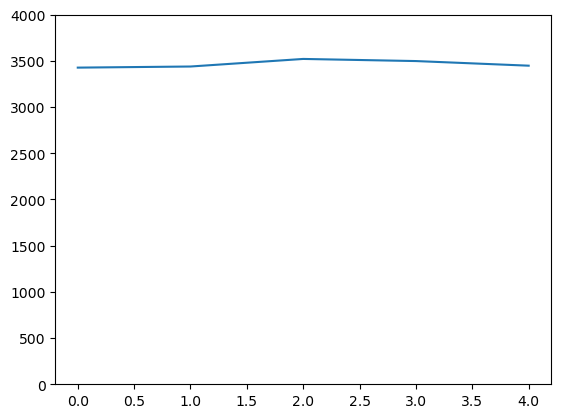

17363


In [25]:
# Generate class cutoffs
# *EXECUTE*
# We have 3664, 3202, 3281, 3761, 3425 in each class, respectively

points = list(df.total_reviews)
points.sort()
#points = np.log(np.log(points))
num_classes = 5
class_count = math.floor(len(df) / (num_classes))
class_cutoffs = [5] + [points[class_count * i] for i in range(1, num_classes)] + [points[-1]]
print("Cutoffs:", class_cutoffs)
a, _, _ = plt.hist(points[:-30], bins=class_cutoffs, log=True)
plt.clf()
print("# Per Class:", list(a))
plt.plot(a)
plt.ylim(0, 4000)
plt.show()
print(len(df))


1539.111847031043
-0.9741150046728895
-0.3700817004779178
-0.14467725903676332
0.09375339668196925
0.35834105702874064
1.254379966189337


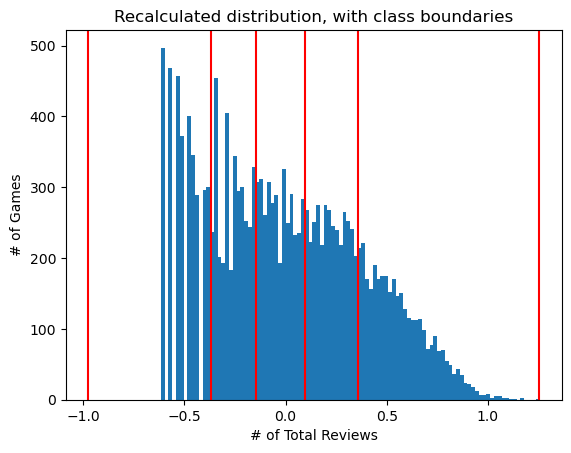

22177


In [38]:
# View distribution of actual data
points = np.array(list(df.total_reviews))
srt_points = list(df.total_reviews)
srt_points.sort()
#points = np.log(np.log(points)) - 1.45
print(np.mean(points))
#points = np.power(points, 0.1)
#plt.hist(points, bins=100)
plt.hist(np.log(np.log(points)) - 1.45, bins=100)
for x in np.log(np.log(class_cutoffs)) - 1.45:
    plt.axvline(x=x, color="r")
    print(x)
plt.plot()
plt.xlabel("# of Total Reviews")
plt.ylabel("# of Games")
plt.title("Recalculated distribution, with class boundaries")
plt.show()
print(srt_points[round(len(srt_points) * 0.99)])

In [27]:
# Generate classes
# *EXECUTE*
chosen_cutoffs = [0, 19, 40, 108, 446, 4000000]

cl = []
ineach = [0] * 5
for i, r in df.iterrows():
    ind = 0
    while r.total_reviews >= chosen_cutoffs[ind]:
        ind += 1
    cl.append(ind - 1)
    ineach[ind - 1] += 1

df["data_class"] = cl
print(ineach)

[3427, 3439, 3521, 3498, 3478]


In [28]:
# Cleaning
# *EXECUTE*
nltk.download('punkt')
nltk.download('stopwords')
stemmer = nltk.stem.porter.PorterStemmer()

_cache = {}

def tokenize(s, other_rm):
    # Preprocess filter
    other_rm = other_rm.lower()
    other_rm = other_rm.split(",")
    other_rm = [i.strip() for i in other_rm]
    
    # Keep alphabetical or space only
    s = re.sub('[^A-Za-z0-9]', ' ', s)
    
    # To lower case
    s = s.lower()
    
    # Remove special words
    for i in other_rm:
        s = s.replace(i, " ")
    
    # Tokenize
    s = nltk.tokenize.word_tokenize(s)
    
    # Filter and stem
    n = []
    for word in s:
        if word not in nltk.corpus.stopwords.words('english') and word not in other_rm:
            n.append(stemmer.stem(word))
    return n

def to_word_vectors(df, mf=1000, mdf=0.001):
    tks = []
    for i, r in df.iterrows():
        if str(r.appid) in _cache.keys():
            tokens = _cache[str(r.appid)]
            
        else:
            if i % 100 == 0:
                print(i, "/", len(df))
                save_cache("token_cache")
            
            if not isinstance(r.game_description, str):
                tokens = []
            else:
                tokens = tokenize(r.game_description, str(r["name"]) + "," + str(r.developer) + "," + str(r.publisher))
            
            _cache[str(r.appid)] = tokens
        
        tks.append(" ".join(tokens))

    cv = CountVectorizer(max_features=mf, min_df = 0.001)
    out = cv.fit_transform(tks).toarray()
    return out, cv.get_feature_names_out()

def save_cache(fname):
    with open('data/' + fname + '.json', 'w') as f:
        json.dump(_cache, f)

def load_cache(fname):
    with open('data/' + fname + '.json', 'r') as f:
        _c = json.load(f)
        for k in _c.keys():
            _cache[k] = _c[k]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joseph\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joseph\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Create token array
# *EXECUTE*
load_cache("token_cache")
word_vectors, feature_names = to_word_vectors(df, mf=2000)
#save_cache("token_cache")
#save_cache("token_backup")

# Verification

s = np.sum(word_vectors, axis=0)
farr = []
for i in range(len(feature_names)):
    farr.append((s[i], feature_names[i]))
farr.sort()

print("Found", len(s), "features. Most un/common:")
print(farr[-10:])
print(farr[:10])

Found 2000 features. Most un/common:
[(9146, 'one'), (9812, 'level'), (10711, 'time'), (11175, 'use'), (12827, 'featur'), (13636, 'play'), (14535, 'player'), (15146, 'world'), (20036, 'new'), (51515, 'game')]
[(198, '27'), (198, 'clock'), (199, 'calm'), (199, 'degre'), (199, 'endur'), (199, 'fog'), (199, 'pool'), (199, 'transfer'), (200, 'beneath'), (200, 'cri')]


In [30]:
# Split dataset
# *EXECUTE*
train_index = 0
dev_index = round(len(df) * 0.7)
test_index = round(len(df) * 0.85)

xy = [(word_vectors[i], df.data_class[i]) for i in range(len(df))]

train, dev, test = xy[train_index:dev_index], xy[dev_index:test_index], xy[test_index:]

print(len(train), len(dev), len(test))


12154 2605 2604


With feature vector length 1500
Baseline (Softmax):
0.2622887864823349


C:\Users\Joseph\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


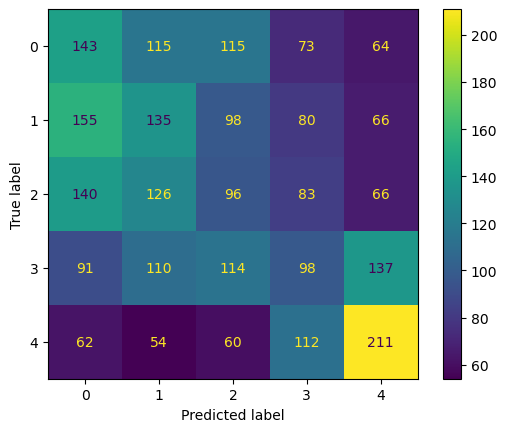

Most/Least impactful features:
[(0.393724463036343, 'imag'), (0.39501314671915383, 'massiv'), (0.4023223341370696, 'necessari'), (0.40604926072258435, 'basic'), (0.41956172816115633, 'optim'), (0.4201637058884845, 'solar'), (0.42736522711006586, 'per'), (0.4313549217544709, 'near'), (0.43780136026738725, 'labyrinth'), (0.45476101367118965, 'franchis')]
[(0.008336012805895267, 'sound'), (0.015660636508040483, 'wood'), (0.017238119575156526, 'game'), (0.017879951340550693, 'famili'), (0.02241699146093403, 'abil'), (0.022862201182117587, 'run'), (0.02401548701031919, 'weapon'), (0.024369880709002277, 'challeng'), (0.025159683310966355, 'strategi'), (0.02538497079363554, 'possibl')]

Naive Bayes:
0.2837941628264209


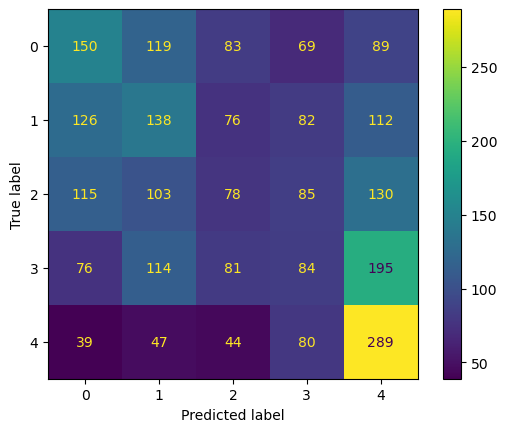

Most/Least impactful features:
[(8.52640460404346, 'chase'), (8.526445494640674, 'desir'), (8.526445494640674, 'wing'), (8.558665466261683, 'count'), (8.558665466261683, 'effici'), (8.558665466261683, 'faith'), (8.561497116972761, '70'), (8.575235658810106, 'assign'), (8.644187639699844, 'whose'), (8.800051146502526, 'la')]
[(3.4630213202654883, 'game'), (4.279497924679239, 'new'), (4.62427161382719, 'player'), (4.632319299301981, 'world'), (4.836335381793936, 'play'), (4.9008984359737715, 'featur'), (4.956218217395021, 'level'), (4.984036422871552, 'use'), (5.0171249366310375, 'time'), (5.1634971519168715, 'mode')]

SVC:


C:\Users\Joseph\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


0.25806451612903225


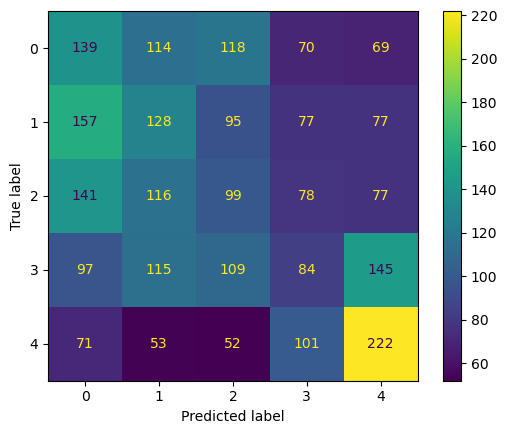

Most/Least impactful features:
[(0.20154285778464825, 'impress'), (0.20387706825012716, 'optim'), (0.2046099015204918, 'vive'), (0.20798837203304113, 'forward'), (0.20900950745227864, 'sent'), (0.20943455267153968, 'written'), (0.22052669289121546, 'franchis'), (0.22229052779604971, 'effici'), (0.3035281784261824, 'fi'), (0.36367993191907133, 'sci')]
[(0.0014291650941026918, 'experi'), (0.0015557336451795544, 'br'), (0.002189054000790626, 'famili'), (0.005349385371465834, 'sound'), (0.005386407650043263, 'wood'), (0.005699287660646137, 'ever'), (0.009135876990009553, 'unreal'), (0.00969092410831592, 'abil'), (0.010154483710267339, 'monster'), (0.010166876792329391, 'game')]

[[0.2622887864823349], [0.2837941628264209], [0.25806451612903225]]


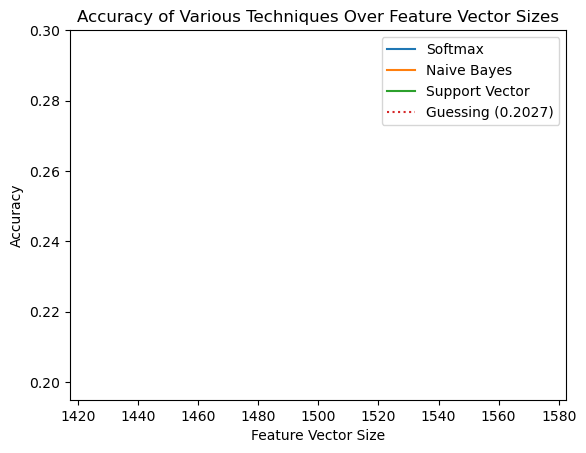

In [55]:
# Generate figure 4
# *EXECUTE*
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def process(m):
    model = make_pipeline(StandardScaler(), m)
    m.fit(word_vectors[:len(train)], df.data_class[:len(train)])
    acc = m.score(word_vectors[len(train):len(train) + len(dev)], df.data_class[len(train):len(train) + len(dev)])
    print(acc)
    pred = m.predict(word_vectors[len(train):len(train) + len(dev)])
    ConfusionMatrixDisplay(confusion_matrix(df.data_class[len(train):len(train) + len(dev)], pred)).plot()
    plt.show()
    return acc

def process_test(m):
    model = make_pipeline(StandardScaler(), m)
    m.fit(word_vectors[:len(train)], df.data_class[:len(train)])
    acc = m.score(word_vectors[len(train) + len(dev):], df.data_class[len(train) + len(dev):])
    print(acc)
    pred = m.predict(word_vectors[len(train) + len(dev):])
    ConfusionMatrixDisplay(confusion_matrix(df.data_class[len(train) + len(dev):], pred)).plot()
    plt.show()
    return acc

def find_feature_importance(model):
    fmax = model.coef_.max(axis=0)

    arr = []
    for i in range(len(feature_names)):
        arr.append((abs(fmax[i]), feature_names[i]))
    arr.sort()

    print("Most/Least impactful features:")
    print(arr[-10:])
    print(arr[:10])

res = [[], [], []]

def run_test(i):
    global word_vectors
    global feature_names
    print("With feature vector length", i)
    #load_cache("token_cache")
    word_vectors, feature_names = to_word_vectors(df, mf=i)
    
    print("Baseline (Softmax):")
    m = LogisticRegression(solver="sag", max_iter=1000)
    res[0].append(process_test(m))
    find_feature_importance(m)
    print()

    print("Naive Bayes:")
    m = MultinomialNB()
    res[1].append(process_test(m))
    find_feature_importance(m)
    print()
    
    print("SVC:")
    m = LinearSVC(dual=False)
    res[2].append(process_test(m))
    find_feature_importance(m)
    print()

#fsizes = [10, 25, 50, 100, 250, 500, 750, 1000, 1250, 1500, 2000, 2500, 3000]
fsizes = [1500]
for fsize in fsizes:
    run_test(fsize)

print(res)

plt.plot(fsizes, res[0], label="Softmax")
plt.plot(fsizes, res[1], label="Naive Bayes")
plt.plot(fsizes, res[2], label="Support Vector")
plt.plot([fsizes[0], fsizes[-1]], [0.2027, 0.2027], linestyle="dotted", label="Guessing (0.2027)")
plt.xlabel("Feature Vector Size")
plt.ylabel("Accuracy")
plt.ylim(0.195, 0.3)
plt.title("Accuracy of Various Techniques Over Feature Vector Sizes")
plt.legend()
plt.show()

With feature vector length 100
Naive Bayes:
0.271785028790787


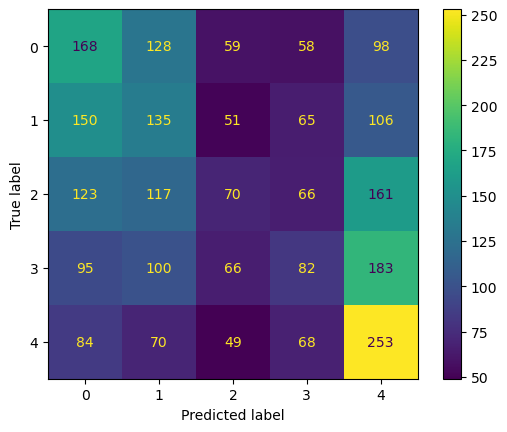

Most/Least impactful features:
[(5.109450065362595, 'space'), (5.110671056358877, 'turn'), (5.1210168908670095, 'becom'), (5.12570086155826, 'unit'), (5.129630094619024, 'allow'), (5.1390330788033065, 'mysteri'), (5.165419264790733, 'chang'), (5.171833650210264, 'best'), (5.1837004099152955, 'day'), (5.227892686531176, 'well')]
[(2.3360519853617916, 'game'), (3.2007836766248463, 'new'), (3.545627503459915, 'player'), (3.5536771323716483, 'world'), (3.7577480901772446, 'play'), (3.774903662187061, 'featur'), (3.829647849052721, 'level'), (3.8574805727739676, 'use'), (3.895835779349664, 'time'), (4.085024950431083, 'mode')]

Naive Bayes:
0.271785028790787


C:\Users\Joseph\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


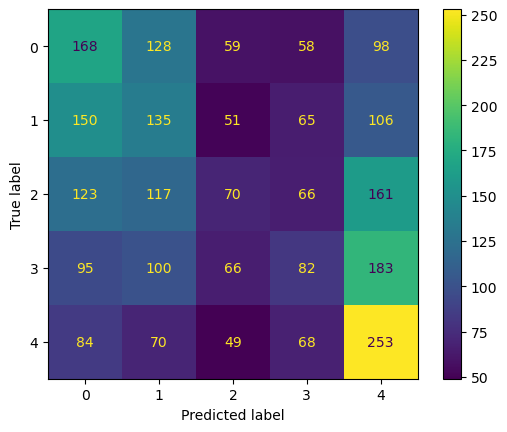


Naive Bayes:
0.271785028790787


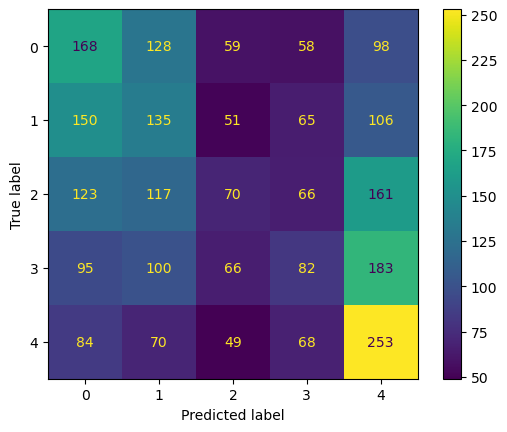


Naive Bayes:
0.271785028790787


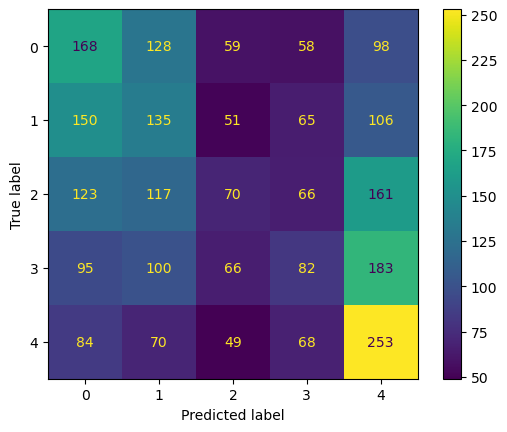


With feature vector length 250
Naive Bayes:
0.271785028790787


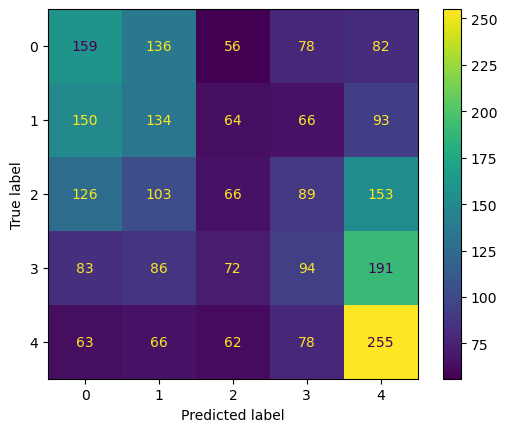

Most/Least impactful features:
[(6.12450058186435, 'everyth'), (6.129365399018933, 'let'), (6.133661861052438, 'know'), (6.140583201881886, 'physic'), (6.1423105636109705, 'dungeon'), (6.147471239103939, 'made'), (6.15459884827023, 'call'), (6.1554255056887985, 'top'), (6.184669103330802, 'rpg'), (6.1867129739300974, 'progress')]
[(2.8035739981297976, 'game'), (3.6347306740001333, 'new'), (3.979574500835202, 'player'), (3.9876241297469353, 'world'), (4.191695087552532, 'play'), (4.242425674955067, 'featur'), (4.297169861820727, 'level'), (4.325002585541974, 'use'), (4.355548733752061, 'time'), (4.51897194780637, 'mode')]

Naive Bayes:
0.271785028790787


C:\Users\Joseph\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


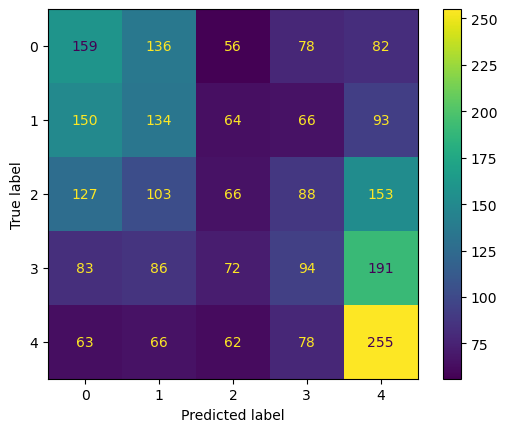


Naive Bayes:
0.27216890595009596


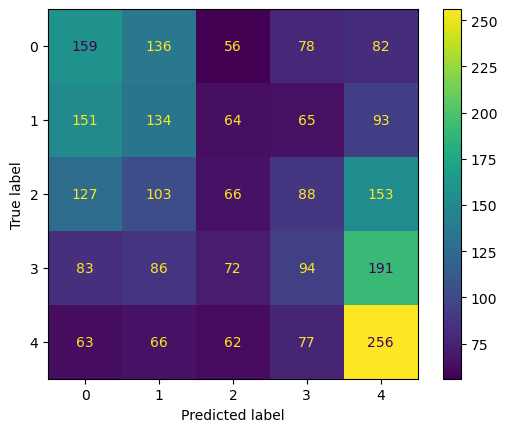


Naive Bayes:
0.27216890595009596


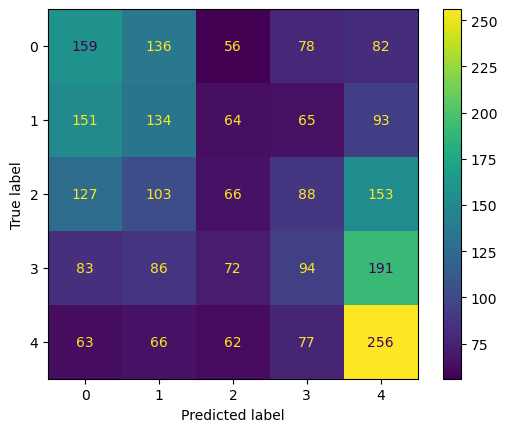


With feature vector length 500
Naive Bayes:
0.27140115163147793


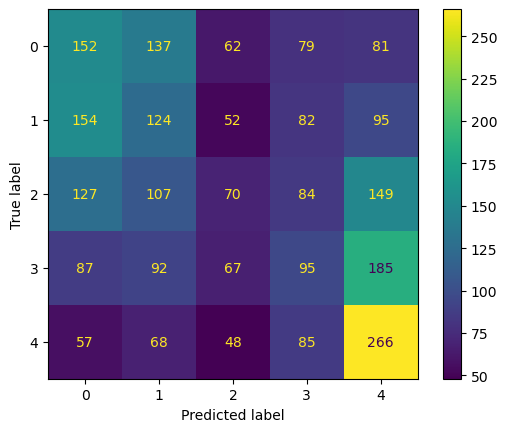

Most/Least impactful features:
[(7.027715916592891, 'decis'), (7.027715916592891, 'known'), (7.027772766790612, 'famili'), (7.035600595410859, 'hit'), (7.0430418870711184, 'construct'), (7.0430418870711184, 'might'), (7.043296698341525, 'air'), (7.049846582259621, 'other'), (7.05860640361223, 'alon'), (7.0675394379186915, 'complex')]
[(3.1038520102249016, 'game'), (3.9223168234779884, 'new'), (4.267160650313057, 'player'), (4.27521027922479, 'world'), (4.479281237030387, 'play'), (4.539764828733024, 'featur'), (4.597447873915831, 'level'), (4.625280597637078, 'use'), (4.655782141597715, 'time'), (4.806558097284225, 'mode')]

Naive Bayes:
0.27140115163147793


C:\Users\Joseph\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


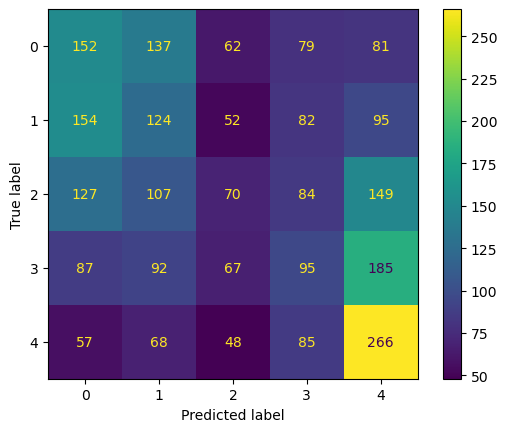


Naive Bayes:
0.271785028790787


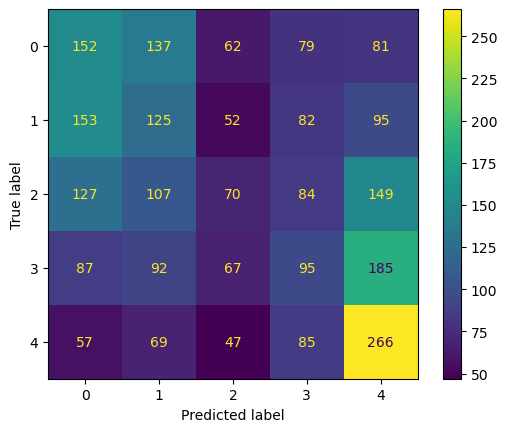


Naive Bayes:
0.27140115163147793


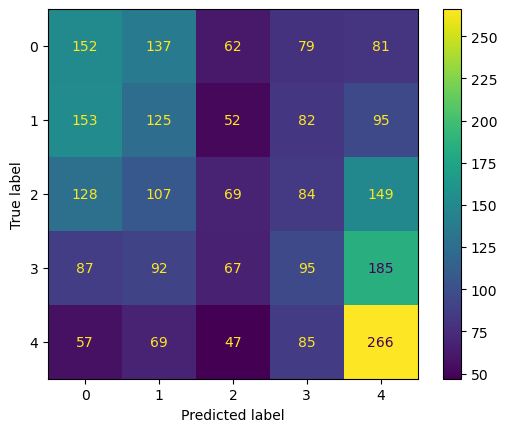


With feature vector length 750
Naive Bayes:
0.27332053742802304


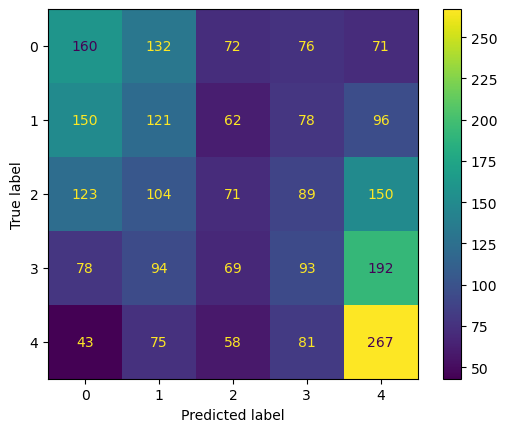

C:\Users\Joseph\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


Most/Least impactful features:
[(7.57051868295642, 'caus'), (7.572213684514178, 'list'), (7.578051675263966, 'hide'), (7.578051675263966, 'leader'), (7.578051675263966, 'seek'), (7.589764254906801, 'surround'), (7.607905341977451, 'deal'), (7.607905341977451, 'mountain'), (7.608764261951496, 'suit'), (7.645205703390659, 'opportun')]
[(3.2515614998090587, 'game'), (4.072874693161488, 'new'), (4.417718519996557, 'player'), (4.42576814890829, 'world'), (4.629839106713886, 'play'), (4.690072765061834, 'featur'), (4.745157363499988, 'level'), (4.772990087221235, 'use'), (4.803948470337989, 'time'), (4.9571159669677245, 'mode')]

Naive Bayes:
0.272552783109405


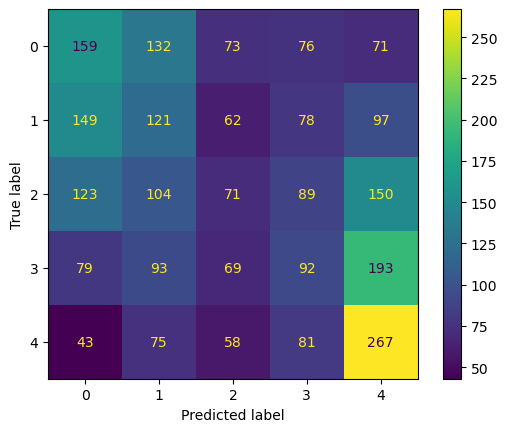


Naive Bayes:
0.27216890595009596


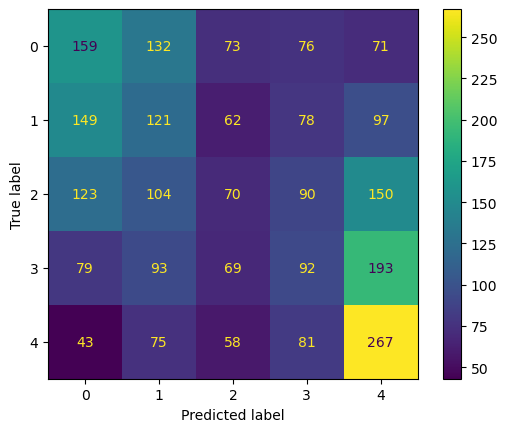


Naive Bayes:
0.27216890595009596


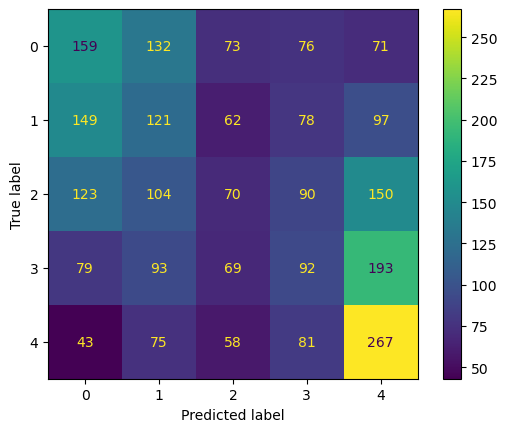


With feature vector length 1000
Naive Bayes:
0.27600767754318617


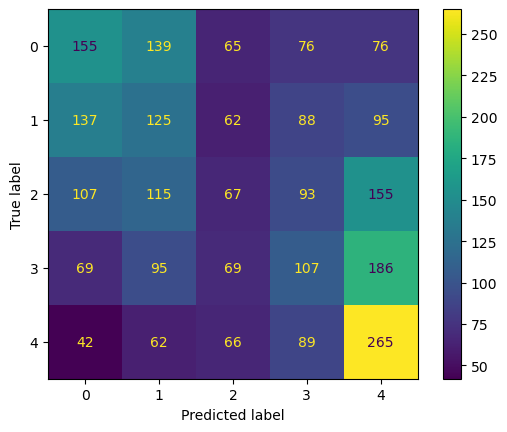

Most/Least impactful features:
[(7.930314704159864, 'lie'), (7.937416103173508, 'simpli'), (7.968154979629067, 'artifact'), (7.970453871750208, 'climb'), (7.984902769439496, 'pay'), (7.984902769439496, 'talent'), (7.984902769439496, 'wheel'), (7.997262373881315, 'ensur'), (8.026294939694427, 'safe'), (8.070896654781054, 'handl')]
[(3.346895271448602, 'game'), (4.163896335047239, 'new'), (4.508740161882308, 'player'), (4.516789790794041, 'world'), (4.7208607485996374, 'play'), (4.783194748193661, 'featur'), (4.840491135139532, 'level'), (4.868323858860778, 'use'), (4.898361167171554, 'time'), (5.048137608853476, 'mode')]

Naive Bayes:


C:\Users\Joseph\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


0.27523992322456814


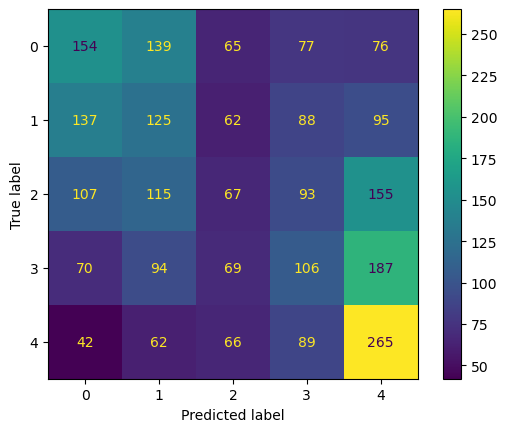


Naive Bayes:
0.2756238003838772


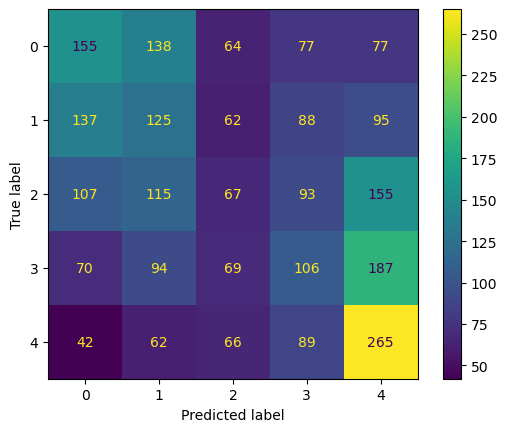


Naive Bayes:
0.2756238003838772


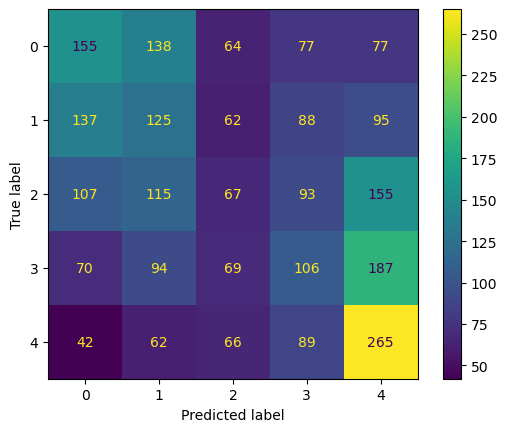


[[0.271785028790787, 0.271785028790787, 0.27140115163147793, 0.27332053742802304, 0.27600767754318617], [0.271785028790787, 0.271785028790787, 0.27140115163147793, 0.272552783109405, 0.27523992322456814], [0.271785028790787, 0.27216890595009596, 0.271785028790787, 0.27216890595009596, 0.2756238003838772], [0.271785028790787, 0.27216890595009596, 0.27140115163147793, 0.27216890595009596, 0.2756238003838772]]


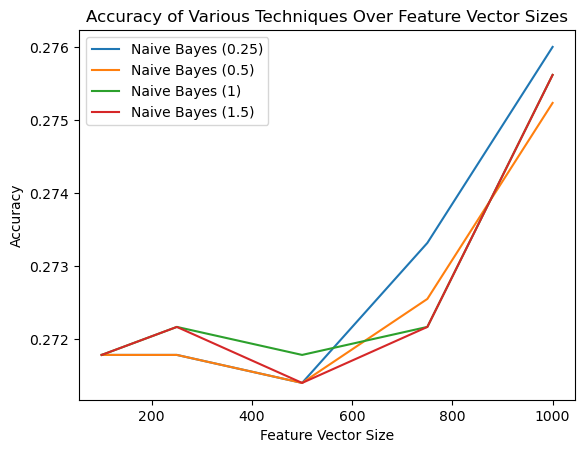

In [49]:
# Generate fig 2
# *EXECUTE*
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def process(m):
    model = make_pipeline(StandardScaler(), m)
    m.fit(word_vectors[:len(train)], df.data_class[:len(train)])
    acc = m.score(word_vectors[len(train):len(train) + len(dev)], df.data_class[len(train):len(train) + len(dev)])
    print(acc)
    pred = m.predict(word_vectors[len(train):len(train) + len(dev)])
    ConfusionMatrixDisplay(confusion_matrix(df.data_class[len(train):len(train) + len(dev)], pred)).plot()
    plt.show()
    return acc

def find_feature_importance(model):
    fmax = model.coef_.max(axis=0)

    arr = []
    for i in range(len(feature_names)):
        arr.append((abs(fmax[i]), feature_names[i]))
    arr.sort()

    print("Most/Least impactful features:")
    print(arr[-10:])
    print(arr[:10])

res = [[], [], [], []]

def run_test(i):
    global word_vectors
    global feature_names
    print("With feature vector length", i)
    #load_cache("token_cache")
    word_vectors, feature_names = to_word_vectors(df, mf=i)
    
    
    print("Naive Bayes:")
    m = MultinomialNB(alpha=0.25)
    res[0].append(process(m))
    find_feature_importance(m)
    print()
    
    
    print("Naive Bayes:")
    m = MultinomialNB(alpha=0.5)
    res[1].append(process(m))
    #find_feature_importance(m)
    print()
    
    
    print("Naive Bayes:")
    m = MultinomialNB(alpha=1)
    res[2].append(process(m))
    #find_feature_importance(m)
    print()
    
    print("Naive Bayes:")
    m = MultinomialNB(alpha=1.5)
    res[3].append(process(m))
    #find_feature_importance(m)
    print()

fsizes = [100, 250, 500, 750, 1000]
for fsize in fsizes:
    run_test(fsize)

print(res)

plt.plot(fsizes, res[0], label="Naive Bayes (0.25)")
plt.plot(fsizes, res[1], label="Naive Bayes (0.5)")
plt.plot(fsizes, res[2], label="Naive Bayes (1)")
plt.plot(fsizes, res[3], label="Naive Bayes (1.5)")
#plt.plot([fsizes[0], fsizes[-1]], [0.2027, 0.2027], linestyle="dotted", label="Guessing (0.2027)")
plt.xlabel("Feature Vector Size")
plt.ylabel("Accuracy")
#plt.ylim(0.195, 0.3)
plt.title("Accuracy of Various Techniques Over Feature Vector Sizes")
plt.legend()
plt.show()

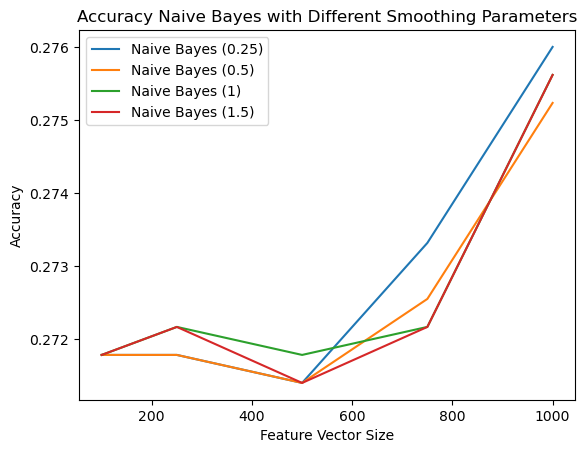

In [50]:
plt.plot(fsizes, res[0], label="Naive Bayes (0.25)")
plt.plot(fsizes, res[1], label="Naive Bayes (0.5)")
plt.plot(fsizes, res[2], label="Naive Bayes (1)")
plt.plot(fsizes, res[3], label="Naive Bayes (1.5)")
#plt.plot([fsizes[0], fsizes[-1]], [0.2027, 0.2027], linestyle="dotted", label="Guessing (0.2027)")
plt.xlabel("Feature Vector Size")
plt.ylabel("Accuracy")
#plt.ylim(0.195, 0.3)
plt.title("Accuracy Naive Bayes with Different Smoothing Parameters")
plt.legend()
plt.show()